In [274]:
# imports

import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm
from glob import glob
import networkx as nx
import itertools
from collections import defaultdict
import re
import nltk
import json

import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import plotly.express as px
import plotly.graph_objects as go
import plotly

In [2]:
# setups

pd.options.display.max_columns = 50
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/albertroethel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# dicts which will contain data frames for each field of knowledge
bio = {}
chem = {}
ph = {}

In [4]:
# load all dfs
for domain, data_dict in tqdm(zip(['biology', 'chemistry', 'physics'], [bio, chem, ph])):
    for path in glob(f'{domain}/*.csv'):
        print(path)
        name = path.split('/')[-1].split('.')[0]
        data_dict[name] = pd.read_csv(path, index_col=0)

|          | 0/? [00:00<?, ?it/s]

biology/PostLinks.csv
biology/PostHistory.csv
biology/Badges.csv
biology/Posts.csv
biology/Users.csv
biology/Tags.csv
biology/Votes.csv
biology/Comments.csv
chemistry/PostLinks.csv
chemistry/PostHistory.csv
chemistry/Badges.csv
chemistry/Posts.csv
chemistry/Users.csv
chemistry/Tags.csv
chemistry/Votes.csv
chemistry/Comments.csv


/Users/albertroethel/anaconda3/envs/nlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


physics/PostLinks.csv
physics/PostHistory.csv


/Users/albertroethel/anaconda3/envs/nlp/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


physics/Badges.csv
physics/Posts.csv


/Users/albertroethel/anaconda3/envs/nlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


physics/Users.csv
physics/Tags.csv
physics/Votes.csv
physics/Comments.csv


/Users/albertroethel/anaconda3/envs/nlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,1,3,4,5,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Tags

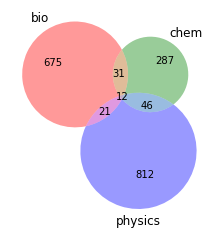

In [5]:
# create sets of tags from each stack
bio_tags = set(bio['Tags'].TagName.tolist())
chem_tags = set(chem['Tags'].TagName.tolist())
ph_tags = set(ph['Tags'].TagName.tolist())
all_tags = bio_tags | chem_tags | ph_tags

# see venn graph of tags 
venn3([bio_tags, chem_tags, ph_tags], set_labels=['bio', 'chem', 'physics'])

In [ ]:
# tags that are in all three domains
bio_tags & chem_tags & ph_tags

In [ ]:
# only in bio and chem not in ph
bio_tags & chem_tags - ph_tags

In [29]:
# remove '<>' from tags
def split_tags(string):
    if isinstance(string, str):
        string = string.lstrip('<').rstrip('>')
        strings = string.split('><')
        return strings
    else:
        return []

In [30]:
for base in [bio, chem, ph]:
    base['Posts']['Tags'] = base['Posts']['Tags'].apply(split_tags)

In [268]:
bio['Posts']['Tags'].head()

0    [ribosome, binding-sites, translation, synthet...
1                                  [rna, biochemistry]
2               [immunology, cell-biology, hematology]
3                                       [cell-culture]
4        [splicing, mrna, spliceosome, introns, exons]
Name: Tags, dtype: object

## Graph analysis

In [ ]:
# create graph where each node is a tag and they are conneted if they cooccur in the same post
# the more frequent they coocur the higher the weight
def create_graph(dbs):
    graph = nx.Graph()
    for db in dbs:
        graph.add_nodes_from(db['Tags'].TagName.tolist())
    tag_pairs_map = defaultdict(int)
    for db in dbs:
        for post_tags in db['Posts']['Tags'].tolist():
            tag_pairs = itertools.combinations(post_tags, r=2)
            for tag1, tag2 in tag_pairs:  # order
                if tag1 > tag2:
                    tag1, tag2 = tag2, tag1
                tag_pairs_map[(tag1, tag2)] += 1

    graph.add_weighted_edges_from(
        [(tag1, tag2, cnt) for (tag1, tag2), cnt in tag_pairs_map.items()]
    )
    return graph
    
tag_graph = create_graph([bio, chem, ph])
bio_graph = create_graph([bio])
chem_graph = create_graph([chem])
ph_graph = create_graph([ph])

In [ ]:
tag_graph.number_of_nodes()

In [ ]:
tag_graph.number_of_edges()

In [ ]:
plt.figure(figsize=(20,20))
nx.draw_kamada_kawai(bio_graph, node_color=tag_colors, edge_color=(0,0,0,0.15))

In [ ]:
# assign color to tags from domains and their combinations
color_assignment = {
    (True, False, False): 1,
    (False, True, False): 2,
    (False, False, True): 3,
    (True, True, False): 4,
    (True, False, True): 5,
    (False, True, True): 6,
    (True, True, True): 7,
}

tag_colors = []
for tag in tag_graph.nodes():
    color = color_assignment[(tag in bio_tags, tag in chem_tags, tag in ph_tags)]
    tag_colors.append(color)

In [ ]:
# plot graph using kamada kawai algorithm
plt.figure(figsize=(20,20))
nx.draw_kamada_kawai(tag_graph, node_color=tag_colors, edge_color=(0,0,0,0.15))

## Tags count and frequency

In [ ]:
# sort tags by frequency
bio_sorted_tags = sorted([(tag, d) for tag, d in bio_graph.degree()], reverse=True, key=lambda x: x[1])
chem_sorted_tags = sorted([(tag, d) for tag, d in chem_graph.degree()], reverse=True, key=lambda x: x[1])
ph_sorted_tags = sorted([(tag, d) for tag, d in ph_graph.degree()], reverse=True, key=lambda x: x[1])
bio_sorted_tags[:20]

In [ ]:
# draw normalized distribution of tag frequency
go.Figure(
    [
        go.Scatter(
            x=list(range(len(bio_sorted_tags))),
            y=[i[1] / max(bio_sorted_tags, key=lambda x: x[1])[1] for i in bio_sorted_tags],
            hovertext=[i[0] for i in bio_sorted_tags],
            name='bio', line_color='green', mode='lines'
        ),
        go.Scatter(
            x=list(range(len(chem_sorted_tags))),
            y=[i[1] / max(chem_sorted_tags, key=lambda x: x[1])[1] for i in chem_sorted_tags],
            hovertext=[i[0] for i in chem_sorted_tags],
            name='chem', line_color='blue', mode='lines'
        ),
        go.Scatter(
            x=list(range(len(ph_sorted_tags))),
            y=[i[1] / max(ph_sorted_tags, key=lambda x: x[1])[1] for i in ph_sorted_tags],
            hovertext=[i[0] for i in ph_sorted_tags],
            name='ph', line_color='red', mode='lines'
        ),
    ]
    
)

## clustering by betweeness centrality - wip

In [ ]:
bio_btw_centrality = nx.edge_betweenness_centrality(bio_graph, normalized=True, weight='weight')

In [ ]:
bio_btw_centrality = sorted(bio_btw_centrality.items(), key=lambda x: x[1], reverse=True)

In [ ]:
bio_graph_clusters = bio_graph.copy()

In [ ]:
len(bio_btw_centrality)

In [ ]:
to_remove = [i[0] for i in bio_btw_centrality[:13000]]
bio_graph_clusters.remove_edges_from(to_remove)

In [ ]:
list(nx.connected_components(bio_graph_clusters))

In [ ]:
sorted(nx.betweenness_centrality(bio_graph).items(), key=lambda x: x[1], reverse=True)[:30]

In [ ]:
sorted(nx.betweenness_centrality(tag_graph).items(), key=lambda x: x[1], reverse=True)[:30]

# Posts texts

In [6]:
# import 
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

In [48]:
import gensim

In [7]:
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import corpus

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer() 

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/albertroethel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Preprocessing

In [8]:
stopwords = corpus.stopwords.words('english')

In [9]:
# removal of html tags
html_tag = re.compile('<.*?>')
new_line = re.compile('\n')

def cleanhtml(raw_html):
    if isinstance(raw_html, str):
        cleantext = re.sub(html_tag, '', raw_html)
        cleantext = re.sub(new_line, ' ', cleantext)
        return cleantext
    else:
        return ''

In [10]:
for db in [bio, chem, ph]:
    db['Posts']['Body'] = db['Posts']['Body'].apply(cleanhtml)

In [11]:
bio['Posts']['Body'][1]

'Does anyone have any suggestions to prevent RNAse contamination when working with RNA?  I tend to have issues with degradation regardless of whether I use DEPC treated / RNAse free water and filtered pipette tips. '

In [102]:
# the most important step of preprocessing
for db in [bio, chem, ph]:
    db['Posts']['words'] = None
    post_words = []
    for Id, data in db['Posts'].groupby(db['Posts'].index):
        words = nltk.word_tokenize(data['Body'].values[0])  # tokenize
        words = [lemmatizer.lemmatize(word) for word in words]  # lemmatize
        words = [word.lower() for word in words if word.isalpha()]  # to lower and remove non-words
        words = [word for word in words if word not in stopwords]  # remove stopwords
        post_words.append(words)
    db['Posts'].loc[:, 'words'] = post_words
del post_words

/Users/albertroethel/anaconda3/envs/nlp/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Users/albertroethel/anaconda3/envs/nlp/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/Users/albertroethel/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/dtypes/missing.py:495: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecat

In [117]:
bio['Posts'].loc[:, 'domain'] = 'bio'
chem['Posts'].loc[:, 'domain'] = 'chem'
ph['Posts'].loc[:, 'domain'] = 'ph'

/Users/albertroethel/anaconda3/envs/nlp/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [118]:
# decrease the number of posts for faster calculations and concatenate dfs
all_posts = pd.concat([bio['Posts'].sample(10000), chem['Posts'].sample(10000), ph['Posts'].sample(10000)])

/Users/albertroethel/anaconda3/envs/nlp/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [121]:
posts_words = all_posts.words.apply(lambda x: ' '.join(x))

# transform words into tfidf vectors
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'}, max_features=3000)
X = vectorizer.fit_transform(posts_words)

/Users/albertroethel/anaconda3/envs/nlp/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [124]:
X.shape

/Users/albertroethel/anaconda3/envs/nlp/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(30000, 3000)

In [125]:
# reduce the dimensionality
X = PCA(50).fit_transform(X.toarray())

/Users/albertroethel/anaconda3/envs/nlp/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [126]:
from sklearn.manifold import TSNE

/Users/albertroethel/anaconda3/envs/nlp/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [142]:
# map 50D space into 2D with t-SNE
tsne = TSNE(2, perplexity=70, n_iter=3000)
mapped = tsne.fit_transform(X)

In [143]:
all_posts.loc[:, 'x_tsne'] = mapped[:, 0]
all_posts.loc[:, 'y_tsne'] = mapped[:, 1]

In [144]:
# visualize t-SNE mapping; show only posts with tags
mask = all_posts['Tags'].apply(lambda x: x != [])
fig = go.Figure()
for domain, data in all_posts.loc[mask].groupby('domain'):
    fig.add_trace(
        go.Scatter(
            x=data.loc[:, 'x_tsne'], y=data.loc[:, 'y_tsne'],
            marker=dict(size=3), mode='markers', name=domain,
            hovertext=data.loc[:, 'Tags'].apply(lambda x: ' '.join(x))
        )
    )
fig.update_layout(
    xaxis=dict(scaleanchor='y', scaleratio=1),
    width=1500, height=1500
).show('browser')

In [269]:
fig

In [270]:
# save calculated figure as json
fig.write_json('tsne.json')

In [ ]:
# load json to make figure
plotly.io.from_json(open('tsne.json', 'r').read())

## Clustering of posts

In [154]:
clustering = AgglomerativeClustering(30).fit(X)

In [157]:
all_posts.loc[:, 'cluster'] = clustering.labels_

In [161]:
all_posts.loc[:, 'tags_joined'] = all_posts.loc[:, 'Tags'].apply(lambda x: ' '.join(x))

In [164]:
px.scatter(
    all_posts.loc[mask],
    x='x_tsne', y='y_tsne',
    color='domain', animation_frame='cluster',
    hover_data=['tags_joined']
).update_layout(
    xaxis=dict(scaleanchor='y', scaleratio=1),
    width=1500, height=1500
).show('browser')

In [181]:
# make df containing clusters, tags and domains
cluster_tags = dict(cluster=[], tags=[], domain=[])
for (cluster, Id), data in all_posts.groupby(['cluster', 'Id']):
    cluster_tags['domain'].append(data['domain'].values[0])
    cluster_tags['tags'].append(data['Tags'].values[0])
    cluster_tags['cluster'].append(cluster)
cluster_tags = pd.DataFrame(cluster_tags).explode('tags')

In [292]:
tags_per_cluster = pd.pivot_table(cluster_tags, index='cluster', columns='tags', aggfunc='count')\
.fillna(0).astype(int)['domain']

In [294]:
top_tags = cluster_tags.tags.value_counts().head(50).index.tolist()
tags_per_cluster.loc[:, top_tags]

tags,organic-chemistry,thermodynamics,quantum-mechanics,inorganic-chemistry,physical-chemistry,homework-and-exercises,biochemistry,human-biology,evolution,genetics,newtonian-mechanics,species-identification,acid-base,electromagnetism,molecular-biology,reaction-mechanism,cell-biology,zoology,dna,entomology,botany,general-relativity,quantum-field-theory,neuroscience,energy,equilibrium,special-relativity,experimental-chemistry,everyday-chemistry,electrochemistry,microbiology,terminology,nomenclature,homework,bioinformatics,quantum-chemistry,redox,forces,proteins,physiology,classical-mechanics,bond,water,aqueous-solution,optics,electrons,computational-chemistry,electrostatics,fluid-dynamics,particle-physics
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,7,8,21,16,19,17,1,5,4,3,5,3,8,7,0,3,3,0,2,1,1,5,6,0,1,12,11,2,2,6,1,4,0,4,1,4,7,1,0,1,3,1,1,4,1,2,1,0,2,2
1,11,31,203,9,16,97,8,7,6,0,71,2,2,26,5,2,4,4,2,3,0,59,58,4,9,0,67,1,5,1,3,16,2,3,0,15,3,12,1,3,41,1,1,2,5,5,9,0,8,35
2,13,124,6,9,18,17,8,16,9,2,7,1,0,4,6,2,1,1,3,2,2,5,4,13,12,8,4,8,8,1,2,4,0,3,1,4,1,1,2,9,6,0,4,2,1,1,6,0,4,2
3,160,50,70,68,50,83,108,252,156,79,71,239,21,42,55,27,45,155,28,167,64,47,28,106,16,11,40,47,66,13,77,46,32,35,48,17,13,22,18,72,26,5,14,7,77,6,29,6,19,19
4,2,2,3,6,6,32,2,3,1,0,43,1,1,2,0,0,0,3,0,1,0,27,7,0,5,0,10,3,2,1,0,2,0,1,0,0,1,7,0,1,7,0,0,1,2,2,0,0,3,2
5,6,94,0,14,67,12,3,3,2,0,2,0,2,1,1,1,1,4,0,1,2,1,2,3,6,22,0,11,12,8,2,2,0,4,0,1,1,4,0,4,1,1,4,3,1,3,0,0,26,0
6,16,2,39,36,31,1,7,1,0,0,2,0,5,17,1,3,2,0,0,0,1,1,4,0,6,0,4,2,1,13,1,1,0,0,0,51,5,1,1,1,3,19,2,1,2,68,19,6,1,17
7,1,2,6,1,4,18,2,3,0,0,1,0,0,29,0,0,4,0,0,0,0,0,2,21,2,3,0,1,0,19,0,2,0,1,1,2,5,0,0,2,0,0,0,0,0,6,1,9,0,0
8,110,8,1,20,9,0,13,1,0,0,0,0,7,1,4,19,2,0,1,0,0,0,0,0,5,0,0,2,2,0,0,4,17,2,0,5,1,0,4,1,0,65,2,1,0,5,2,0,0,0


In [206]:
cluster_tags.head()

,cluster,tags,domain
0,0,NaN,bio
1,0,acid-base,chem
1,0,equilibrium,chem
1,0,aqueous-solution,chem
2,0,NaN,chem


In [267]:
# get top5 tags per each cluster

def f(x):
    return x.sort_values('domain', ascending=False).head(5).reset_index()['tags'].tolist()

top5 = cluster_tags.groupby(['cluster', 'tags']).count().groupby('cluster').apply(f)
for Id, tags in top5.iteritems():
    print(f'{Id}) {tags}')

0) ['quantum-mechanics', 'physical-chemistry', 'homework-and-exercises', 'inorganic-chemistry', 'equilibrium']
1) ['quantum-mechanics', 'homework-and-exercises', 'newtonian-mechanics', 'special-relativity', 'general-relativity']
2) ['thermodynamics', 'temperature', 'entropy', 'physical-chemistry', 'homework-and-exercises']
3) ['human-biology', 'species-identification', 'entomology', 'organic-chemistry', 'evolution']
4) ['black-holes', 'newtonian-mechanics', 'mass', 'homework-and-exercises', 'general-relativity']
5) ['thermodynamics', 'physical-chemistry', 'gas-laws', 'pressure', 'fluid-dynamics']
6) ['electrons', 'quantum-chemistry', 'molecular-orbital-theory', 'orbitals', 'quantum-mechanics']
7) ['electric-circuits', 'electrical-resistance', 'electricity', 'electromagnetism', 'electric-current']
8) ['organic-chemistry', 'bond', 'inorganic-chemistry', 'reaction-mechanism', 'nomenclature']
9) ['electromagnetism', 'quantum-field-theory', 'magnetic-fields', 'homework-and-exercises', 'fiel

## LDA modelling

In [147]:
# create mapping between words and their int ID
dictionary = gensim.corpora.Dictionary(all_posts.words.tolist())
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=10000)

In [149]:
# translate words into their ID
corpus = [dictionary.doc2bow(text) for text in all_posts.words.tolist()]

In [151]:
# LDA modelling
lda_model = gensim.models.LdaModel(
    corpus,
    id2word=dictionary,
    num_topics=30,
    offset=2,
    random_state=100,
    update_every=1,
    passes=10,
    alpha='auto',
    eta="auto",
    per_word_topics=True
)

In [295]:
# Detected topics
for Id, formula in lda_model.print_topics():
    print(f'{formula}', end='\n\n')

0.467*"r" + 0.047*"clock" + 0.039*"unit" + 0.030*"centre" + 0.030*"ii" + 0.028*"mg" + 0.022*"j" + 0.019*"flame" + 0.017*"ac" + 0.015*"iii"

0.090*"weight" + 0.080*"expansion" + 0.063*"tension" + 0.044*"dimensional" + 0.038*"kg" + 0.034*"bubble" + 0.029*"tr" + 0.027*"chlorine" + 0.022*"parallel" + 0.019*"lewis"

0.142*"frame" + 0.067*"reference" + 0.046*"theorem" + 0.041*"event" + 0.039*"region" + 0.030*"conserved" + 0.030*"two" + 0.022*"one" + 0.021*"rest" + 0.020*"transform"

0.420*"field" + 0.106*"magnetic" + 0.075*"group" + 0.030*"loop" + 0.024*"current" + 0.022*"charged" + 0.021*"line" + 0.019*"optical" + 0.019*"material" + 0.012*"partition"

0.259*"p" + 0.164*"g" + 0.134*"f" + 0.051*"string" + 0.049*"orbit" + 0.026*"pair" + 0.021*"l" + 0.021*"bar" + 0.017*"free" + 0.016*"radical"

0.028*"wheel" + 0.022*"drag" + 0.022*"horizontal" + 0.020*"inner" + 0.020*"brain" + 0.020*"al" + 0.017*"vertical" + 0.017*"et" + 0.016*"arm" + 0.015*"projection"

0.155*"q" + 0.082*"coordinate" + 0.074*"